# Exemple sur le modèle jouet Campbell

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import gpflow

2025-12-16 13:10:20.406171: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-16 13:10:20.448387: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-16 13:10:23.127263: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
%reload_ext autoreload
%autoreload 2
import sys
from pathlib import Path

sys.path.append(str(Path().resolve().parent))
import Methodes.model_class as model_class
import Methodes.Design_of_experiment as doe

In [3]:
def Simulateur(x,z1,z2):
  return x[0]*np.exp(-(0.8*z1+0.2*z2-10*x[1])**2/(60*x[0]**2))+(x[1]+x[3])*np.exp((0.5*z1+0.5*z2)*x[0]/500)+x[4]*(x[2]-2)*np.exp(-(0.4*z1+0.6*z2-20*x[5])**2/(40*x[4]**2))+(x[5]+x[7])*np.exp((0.3*z1+0.7*z2)*x[6]/250)

#x=np.array([-1,-1,-1,-1,-1,-1,-1,-1])
#x=np.array([5,5,5,5,5,5,5,5])
x=np.array([5,3,1,-1,5,3,1,-1])

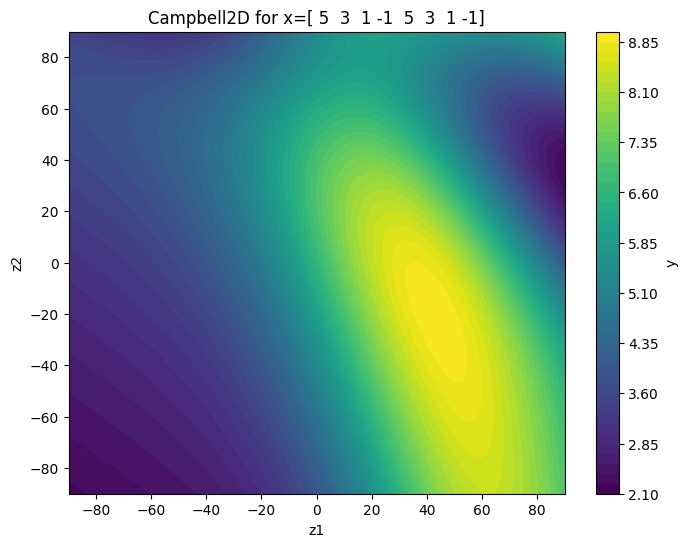

In [4]:
n_grid = 64
D = n_grid**2
z1_vals=np.linspace(-90,90,n_grid)
z2_vals=np.linspace(-90,90,n_grid)

Z1,Z2=np.meshgrid(z1_vals,z2_vals)

Y = Simulateur(x, Z1, Z2)
plt.figure(figsize=(8, 6))
contour = plt.contourf(Z1, Z2, Y, levels=50)
plt.colorbar(contour, label='y')
plt.xlabel('z1')
plt.ylabel('z2')
plt.title(f'Campbell2D for x={x}')
plt.show()

In [5]:
n_train = 200
n_dim = 8
bounds = np.array([-np.ones(n_dim),5*np.ones(n_dim)])
x_train = doe.lhs_optimized(n_train, n_dim ,bounds, n_iter=500, seed=42)#on simule les données d'entrée avec un hypercube latin optimisé
y_train = np.zeros((n_train,n_grid*n_grid))  # matrice (200, 4096)
for i in range(n_train):
    ytrain_i = Simulateur(x_train[i], Z1, Z2)
    y_train[i,:] = ytrain_i.flatten()
print("Forme de y_train :",y_train.shape)

n_test = 1000
x_test=np.random.uniform(-1,5,(n_test,8))
y_test = np.zeros((n_test,n_grid*n_grid))
for i in range(n_test):
    ytest_i = Simulateur(x_test[i], Z1, Z2)
    y_test[i,:] = ytest_i.flatten()
print("Forme de y_test :",y_test.shape)

Forme de y_train : (200, 4096)
Forme de y_test : (1000, 4096)


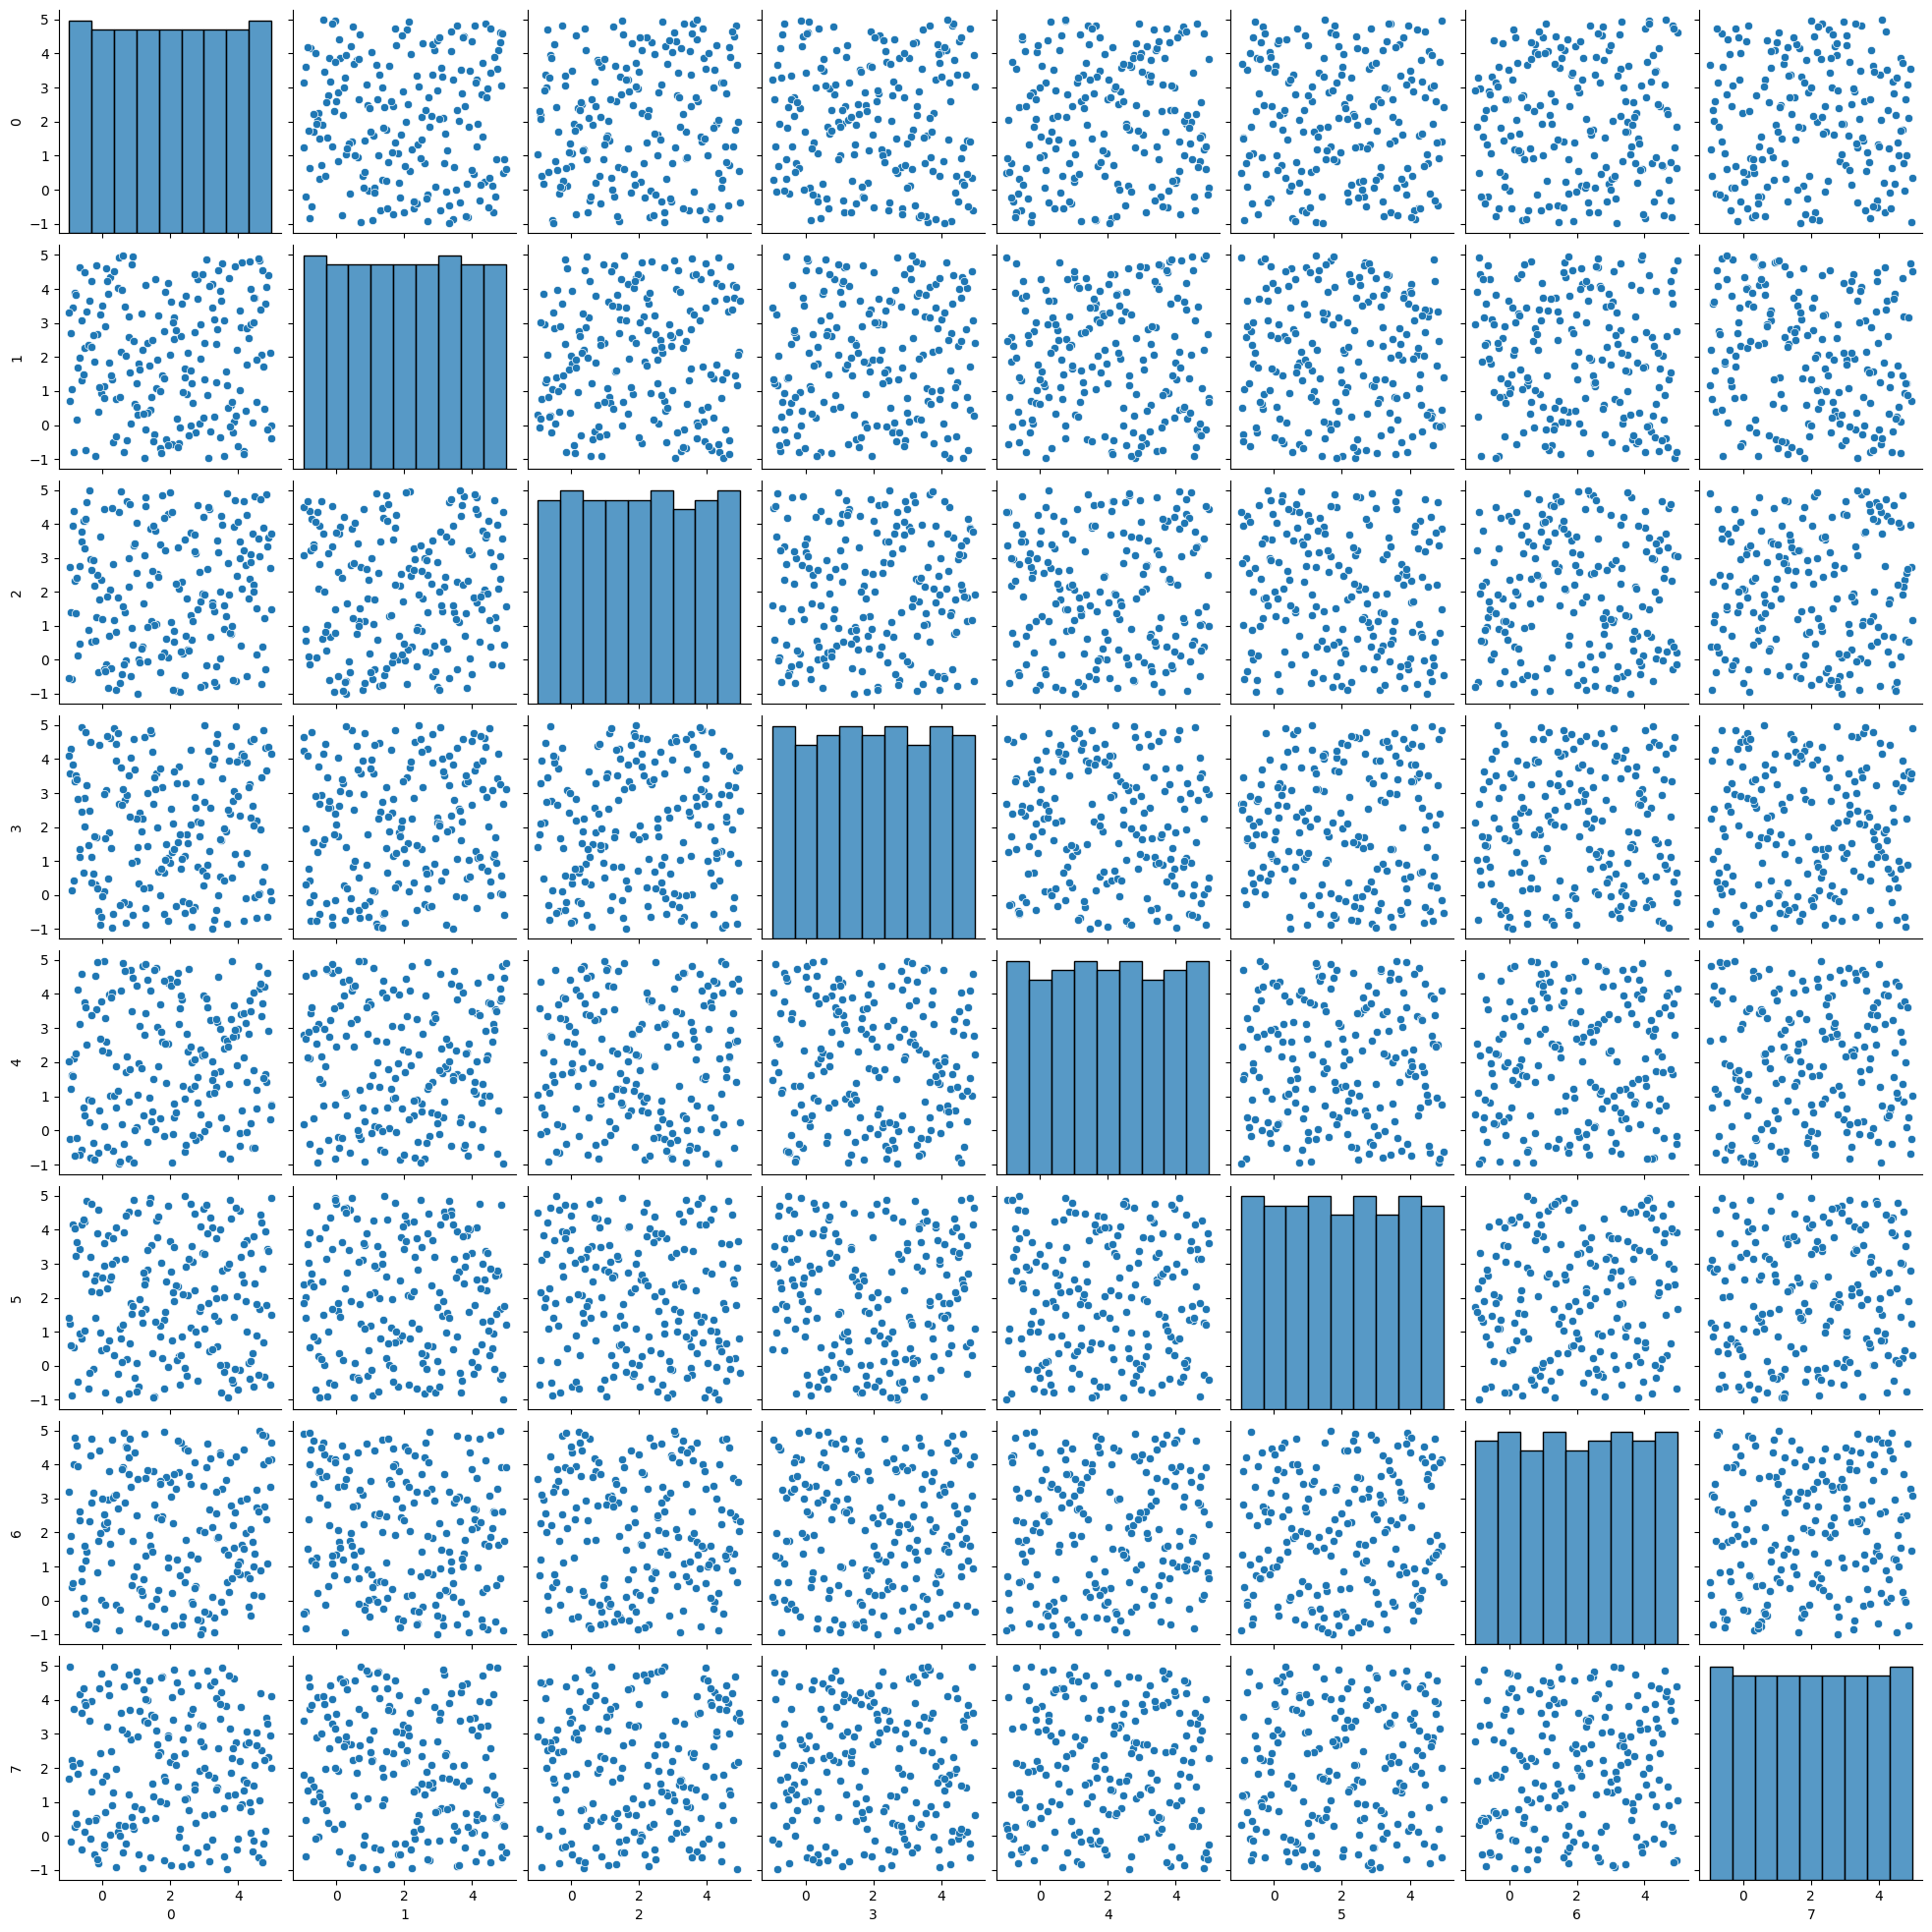

In [6]:
# Affichage des points d'entrainements choisis
sns.pairplot(pd.DataFrame(x_train))

On va ajouter du bruit à nos données d'entrées pour s'assurer de la robustesse de nos méthodes.

In [7]:
eps = 1e-3
x_train += eps*np.random.normal(size=x_train.shape)
x_test += eps*np.random.normal(size=x_test.shape)

In [8]:
n_pc = 5  # On choisit arbitrairement le nombre de composantes principales (d'après la thèse, 5 semble un bon compromis)
theta = 3 # On choisit arbitrairement la valeur de theta 
sigma = 1 # et de sigma
param = [theta, sigma]

kernel = gpflow.kernels.SquaredExponential(lengthscales=param[0], variance=param[1]**2) + gpflow.kernels.White(variance=1e-6)

I0000 00:00:1765887044.904023   12880 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1081 MB memory:  -> device: 0, name: NVIDIA RTX 2000 Ada Generation, pci bus id: 0000:55:00.0, compute capability: 8.9


## On entraine nos 3 méthodes :

In [9]:
# ACP
ACP = model_class.ACP_classique(n_pc,[theta,sigma])
ACP.train(x_train,y_train,kernel_fn=kernel)


--- Entraînement du modèle GP pour la composante principale  1 ---
Modèle GP créé pour la composante principale  1 . Optimisation des hyperparamètres...


I0000 00:00:1765887048.041640   13020 cuda_solvers.cc:175] Creating GpuSolver handles for stream 0x417bd8a0


Optimisation terminée.

--- Entraînement du modèle GP pour la composante principale  2 ---
Modèle GP créé pour la composante principale  2 . Optimisation des hyperparamètres...
Optimisation terminée.

--- Entraînement du modèle GP pour la composante principale  3 ---
Modèle GP créé pour la composante principale  3 . Optimisation des hyperparamètres...
Optimisation terminée.

--- Entraînement du modèle GP pour la composante principale  4 ---
Modèle GP créé pour la composante principale  4 . Optimisation des hyperparamètres...
Optimisation terminée.

--- Entraînement du modèle GP pour la composante principale  5 ---
Modèle GP créé pour la composante principale  5 . Optimisation des hyperparamètres...
Optimisation terminée.
--- Analyse en Composantes Principales ---
Variance expliquée par les 5 premières composantes : [0.77542983 0.13512075 0.03266067 0.0195173  0.01679901]
Variance globale expliquée : 0.9795275725785993
Taille du jeu d'entrainement transformé par ACP : (200, 5)


In [10]:
# B-spline
txy = np.concatenate((
    np.repeat(-90, 2),
    np.arange(-80, 91, 10),
    np.repeat( 90, 2)
))
print("Le vecteur de noeuds utilisé pour la décompostion B-spline :",txy)
noeuds=[txy,txy]
domaine=[z1_vals,z2_vals]

Bsplines = model_class.ACPF_Bsplines(n_pc,[theta,sigma],noeuds,domaine)
Bsplines.train(x_train,y_train,kernel_fn=kernel)

Le vecteur de noeuds utilisé pour la décompostion B-spline : [-90 -90 -80 -70 -60 -50 -40 -30 -20 -10   0  10  20  30  40  50  60  70
  80  90  90  90]

--- Entraînement du modèle GP pour la composante principale  1 ---
Modèle GP créé pour la composante principale  1 . Optimisation des hyperparamètres...
Optimisation terminée.

--- Entraînement du modèle GP pour la composante principale  2 ---
Modèle GP créé pour la composante principale  2 . Optimisation des hyperparamètres...
Optimisation terminée.

--- Entraînement du modèle GP pour la composante principale  3 ---
Modèle GP créé pour la composante principale  3 . Optimisation des hyperparamètres...
Optimisation terminée.

--- Entraînement du modèle GP pour la composante principale  4 ---
Modèle GP créé pour la composante principale  4 . Optimisation des hyperparamètres...
Optimisation terminée.

--- Entraînement du modèle GP pour la composante principale  5 ---
Modèle GP créé pour la composante principale  5 . Optimisation des hyper

In [11]:
# Ondelettes 
p = 0.99999 #Il faut mettre un p quasiment égal à 1 pour obtenir un résultat satisfaisant
Ondelettes = model_class.ACPF_Ondelettes(n_pc,[theta,sigma],p,2)
Ondelettes.train(x_train,y_train,kernel_fn=kernel)

Nombre de coefficients conservés pour l'ACP : 1617

--- Entraînement du modèle GP pour la composante principale  1 ---
Modèle GP créé pour la composante principale  1 . Optimisation des hyperparamètres...
Optimisation terminée.

--- Entraînement du modèle GP pour la composante principale  2 ---
Modèle GP créé pour la composante principale  2 . Optimisation des hyperparamètres...
Optimisation terminée.

--- Entraînement du modèle GP pour la composante principale  3 ---
Modèle GP créé pour la composante principale  3 . Optimisation des hyperparamètres...
Optimisation terminée.

--- Entraînement du modèle GP pour la composante principale  4 ---
Modèle GP créé pour la composante principale  4 . Optimisation des hyperparamètres...
Optimisation terminée.

--- Entraînement du modèle GP pour la composante principale  5 ---
Modèle GP créé pour la composante principale  5 . Optimisation des hyperparamètres...
Optimisation terminée.
--- Analyse en Composantes Principales ---
Variance expliquée pa

## On fait les prédictions:

In [12]:
Y_test_reconstruct_ACP = ACP.predict(x_test)
Y_test_reconstruct_Bsplines=Bsplines.predict(x_test)
Y_test_reconstruct_wavelet = Ondelettes.predict(x_test)

Prédiction en cours...
Prédiction en cours...
Prédiction en cours...


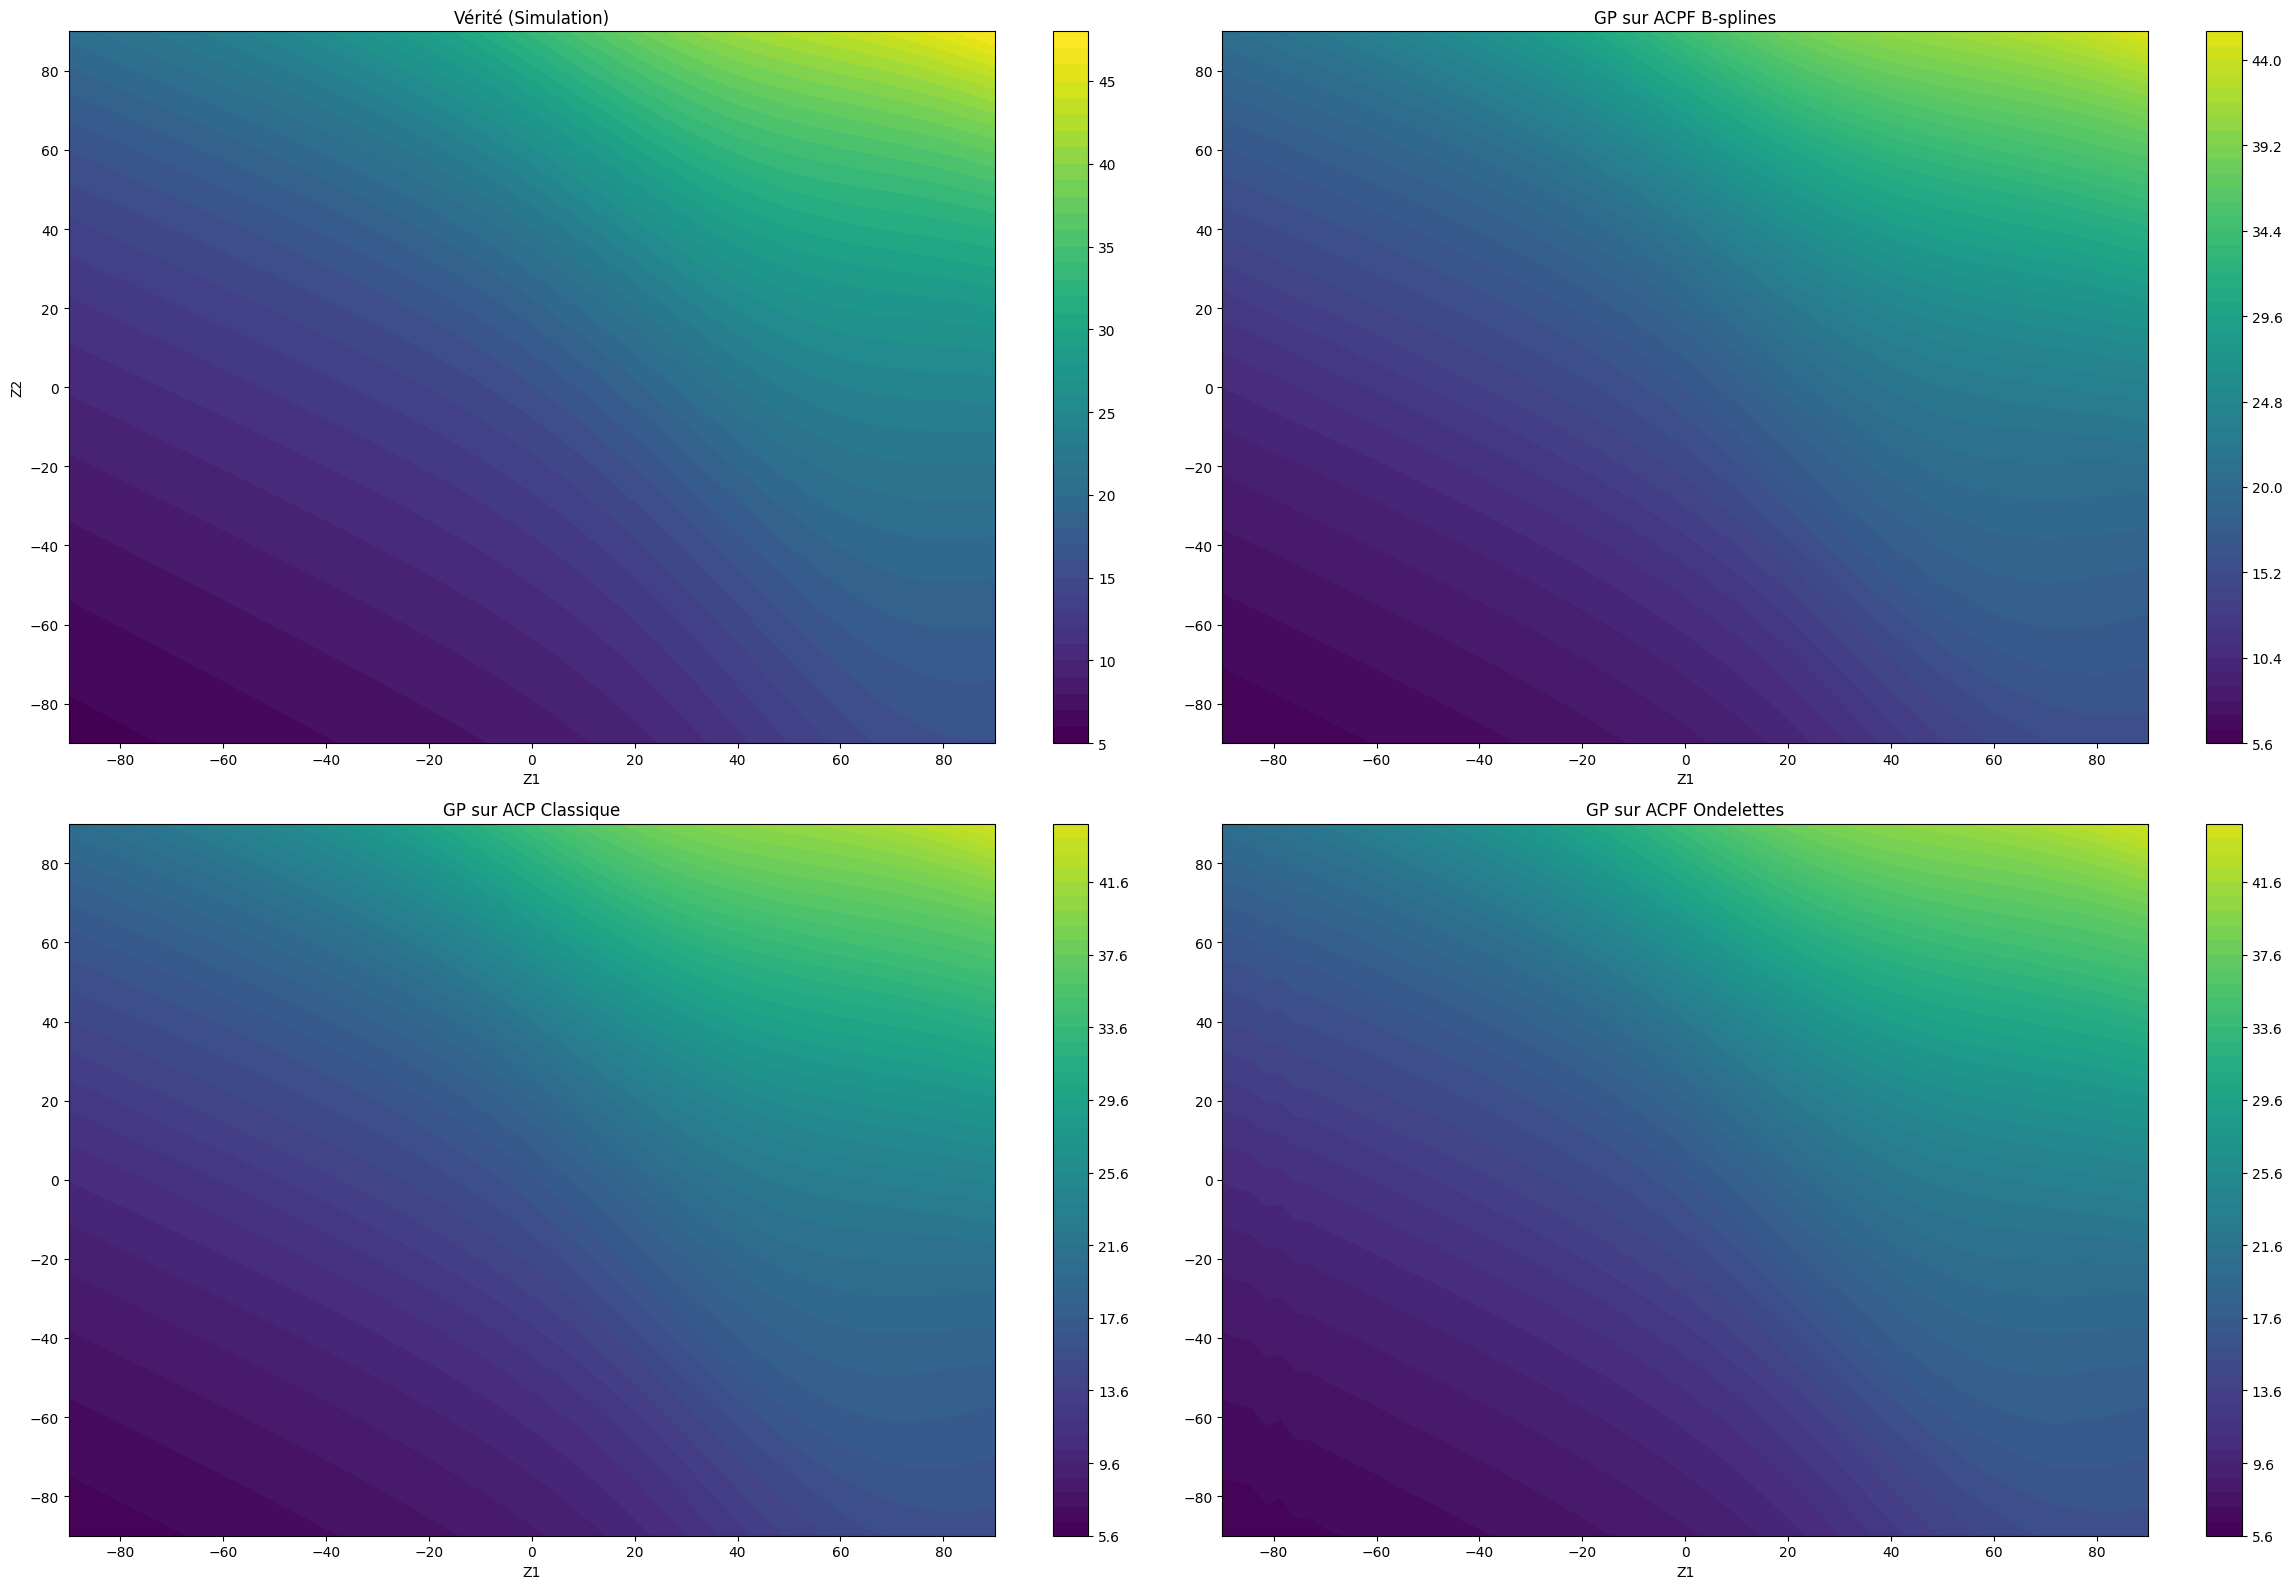

In [13]:
k = 7 #On choisit ici un indice arbitraire pour visualiser une sortie (on peut le changer comme on le souhaite)

# --- Reshape des champs
Y_true = np.reshape(y_test[k, :], (n_grid, n_grid))
Y_bs   = np.reshape(Y_test_reconstruct_Bsplines[k, :], (n_grid, n_grid))
Y_pca  = np.reshape(Y_test_reconstruct_ACP[k, :], (n_grid, n_grid))
Y_wave = np.reshape(Y_test_reconstruct_wavelet[k, :], (n_grid, n_grid))

# --- Trouver les min/max communs pour la même échelle colorimétrique
vmin = min(Y_true.min(), Y_bs.min(), Y_pca.min(),Y_wave.min())
vmax = max(Y_true.max(), Y_bs.max(), Y_pca.max(),Y_wave.max())

# --- Plot côte à côte
plt.figure(figsize=(24, 16))

# Vérité
plt.subplot(2, 2, 1)
contour1 = plt.contourf(Z1, Z2, Y_true, levels=50, vmin=vmin, vmax=vmax)
plt.colorbar(contour1)
plt.title("Vérité (Simulation)")
plt.xlabel("Z1")
plt.ylabel("Z2")

# Reconstruction B-splines+ACP + GP
plt.subplot(2, 2, 2)
contour2 = plt.contourf(Z1, Z2, Y_bs, levels=50, vmin=vmin, vmax=vmax)
plt.colorbar(contour2)
plt.title("GP sur ACPF B-splines")
plt.xlabel("Z1")

# Reconstruction ACP + GP
plt.subplot(2, 2, 3)
contour3 = plt.contourf(Z1, Z2, Y_pca, levels=50, vmin=vmin, vmax=vmax)
plt.colorbar(contour3)
plt.title("GP sur ACP Classique")
plt.xlabel("Z1")

# Reconstruction Ondelettes + ACP + GP
plt.subplot(2, 2, 4)
contour4 = plt.contourf(Z1, Z2, Y_wave, levels=50, vmin=vmin, vmax=vmax)
plt.colorbar(contour4)
plt.title("GP sur ACPF Ondelettes")
plt.xlabel("Z1")

plt.tight_layout()
plt.show()


# RMSE

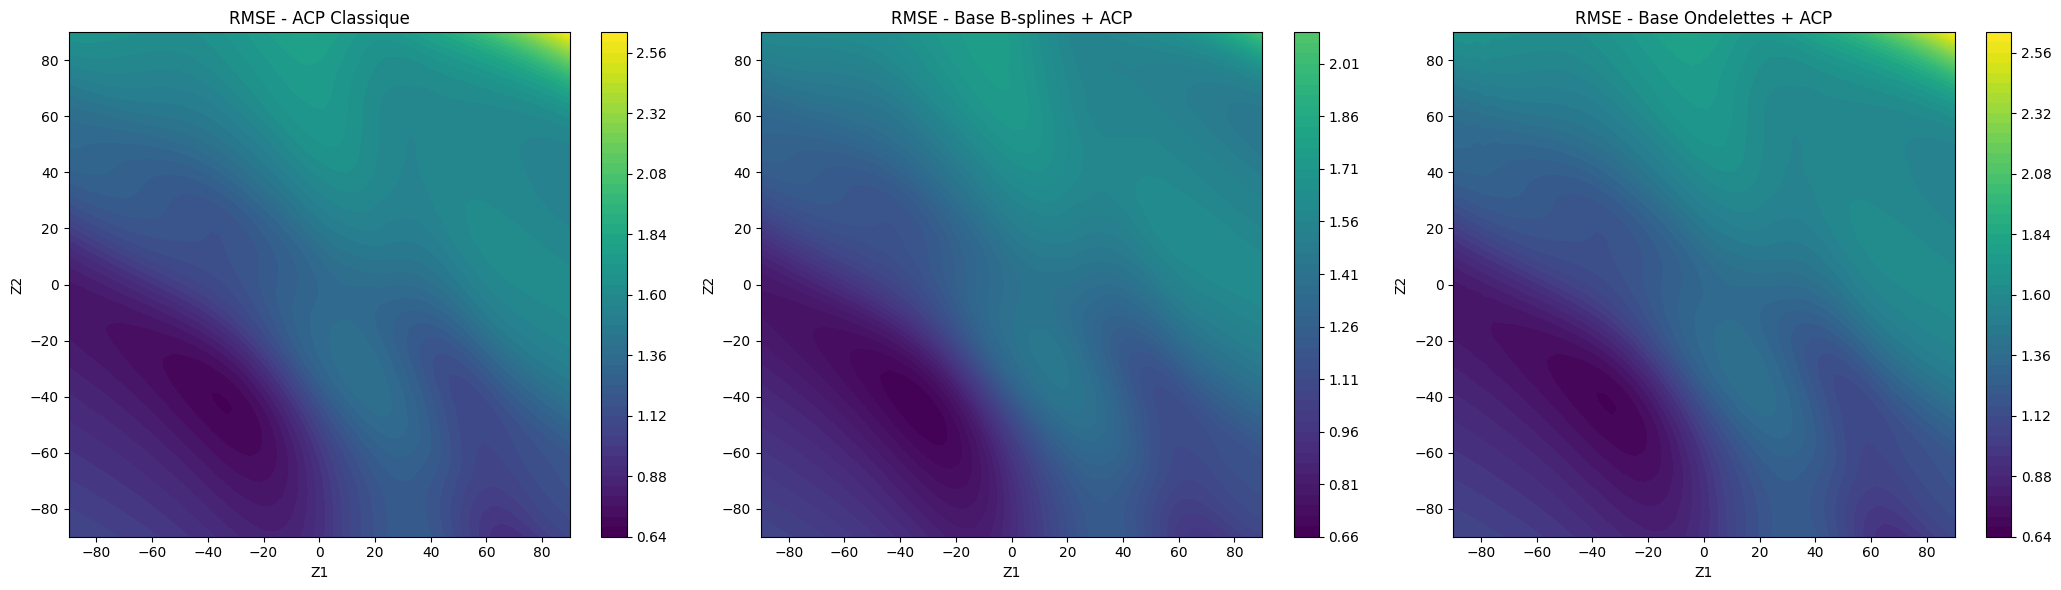

In [14]:
# --- Calcul RMSE pixel-par-pixel (ACP classique)
rmse_ACP = np.sqrt(np.mean((y_test - Y_test_reconstruct_ACP)**2, axis=0))
RMSE_map_ACP = rmse_ACP.reshape((n_grid, n_grid))

# --- Calcul RMSE pixel-par-pixel (B-splines)
rmse_BS = np.sqrt(np.mean((y_test - Y_test_reconstruct_Bsplines)**2, axis=0))
RMSE_map_BS = rmse_BS.reshape((n_grid, n_grid))

# --- Calcul RMSE pixel-par-pixel (Ondelettes)
rmse_wavelet = np.sqrt(np.mean((y_test - Y_test_reconstruct_wavelet)**2, axis=0))
RMSE_map_wavelet = rmse_wavelet.reshape((n_grid, n_grid))

# --- Trouver les min/max communs pour la même échelle colorimétrique
vmin = min(RMSE_map_ACP.min(), RMSE_map_BS.min(), RMSE_map_wavelet.min())
vmax = max(RMSE_map_ACP.max(), RMSE_map_BS.max(), RMSE_map_wavelet.max())

# --- Plot côte à côte
plt.figure(figsize=(21, 6))

# ACP classique
plt.subplot(1, 3, 1)
contour1 = plt.contourf(Z1, Z2, RMSE_map_ACP, levels=50,vmin = vmin, vmax=vmax)
plt.colorbar(contour1)
plt.title("RMSE - ACP Classique")
plt.xlabel("Z1")
plt.ylabel("Z2")

# ACP + B-splines
plt.subplot(1, 3, 2)
contour2 = plt.contourf(Z1, Z2, RMSE_map_BS, levels=50,vmin = vmin, vmax=vmax)
plt.colorbar(contour2)
plt.title("RMSE - Base B-splines + ACP")
plt.xlabel("Z1")
plt.ylabel("Z2")

# ACP + Ondelettes
plt.subplot(1, 3, 3)
contour3 = plt.contourf(Z1, Z2, RMSE_map_wavelet, levels=50,vmin = vmin, vmax=vmax)
plt.colorbar(contour3)
plt.title("RMSE - Base Ondelettes + ACP")
plt.xlabel("Z1")
plt.ylabel("Z2")

plt.tight_layout()
plt.show()

In [15]:
Y_test_reconstruct_ACP = ACP.predict(x_train)  # On prédit sur les données d'entraînement pour vérifier la reconstruction
mse_ACP = np.mean((y_train - Y_test_reconstruct_ACP)**2)
print("MSE ACP sur données d'entraînement :", mse_ACP)

Prédiction en cours...
MSE ACP sur données d'entraînement : 0.5253587711973011
